# <center> **Brief**

[Brief Time series - Sujet du Brief 2025.docx](<Brief Time series - Sujet du Brief 2025 nouvelle version.docx>)

### **Sources**

**Times Series**<br>
https://datascientest.com/series-temporelles-python<br>

**Statsmodels**<br>
https://www.statsmodels.org/stable/index.html<br>

**Test de Dickey-Fuller**<br>
https://fr.wikipedia.org/wiki/Test_de_Dickey-Fuller<br>

**ACF PACF**<br>
https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html#statsmodels.graphics.tsaplots.plot_acf<br>
https://www.geeksforgeeks.org/autocorrelation-and-partial-autocorrelation/<br>
https://support.minitab.com/fr-fr/minitab/help-and-how-to/statistical-modeling/time-series/how-to/partial-autocorrelation/interpret-the-results/partial-autocorrelation-function-pacf/<br>



## **Imports**

In [46]:
import os
import math
import tqdm
import copy
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
# from tabulate import tabulate
#from scipy import stats as st
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, HTML

# Scikit-Learn
from sklearn import linear_model
# from sklearn.metrics import confusion_matrix
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

pd.set_option('display.max_rows', 10)

## **Préparation des données**

In [166]:
df_data = pd.read_csv('GlobalLandTemperaturesByCity.csv', delimiter = ',', low_memory=False)

In [167]:
df_data.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [176]:
df_france = df_data[df_data['Country'] == 'France'][df_data.columns[:4]]
df_brest = df_data[(df_data['City'] == 'Brest') & (df_data['Country'] == 'France')][df_data.columns[:3]]
df_brest.head()

,dt,AverageTemperature,AverageTemperatureUncertainty
1130388,1743-11-01,11.346,1.826
1130389,1743-12-01,NaN,NaN
1130390,1744-01-01,NaN,NaN
1130391,1744-02-01,NaN,NaN
1130392,1744-03-01,NaN,NaN


In [177]:
df_france.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City
117012,1743-11-01,7.478,1.866,Aix En Provence
117013,1743-12-01,NaN,NaN,Aix En Provence
117014,1744-01-01,NaN,NaN,Aix En Provence
117015,1744-02-01,NaN,NaN,Aix En Provence
117016,1744-03-01,NaN,NaN,Aix En Provence


In [171]:
df_brest.dtypes

dt                                object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
dtype: object

### **Suppression des Nan**

In [181]:
df_france_notna = df_france.dropna()
df_brest_notna  = df_brest.dropna()
df_brest_notna.head()

,dt,AverageTemperature,AverageTemperatureUncertainty
1130388,1743-11-01,11.346,1.826
1130393,1744-04-01,9.802,2.184
1130394,1744-05-01,10.264,1.623
1130395,1744-06-01,13.310,1.640
1130396,1744-07-01,14.800,1.716


In [182]:
df_france_notna

,dt,AverageTemperature,AverageTemperatureUncertainty,City
117012,1743-11-01,7.478,1.866,Aix En Provence
117017,1744-04-01,11.596,2.044,Aix En Provence
117018,1744-05-01,13.287,1.791,Aix En Provence
117019,1744-06-01,17.675,1.733,Aix En Provence
117020,1744-07-01,20.056,1.825,Aix En Provence
...,...,...,...,...
8045375,2013-04-01,8.755,0.410,Villeurbanne
8045376,2013-05-01,10.477,0.406,Villeurbanne
8045377,2013-06-01,15.970,0.453,Villeurbanne
8045378,2013-07-01,20.531,0.367,Villeurbanne


### **Convert date to correct dateTime type**

They all are at the correct format 'yyyy-mm-dd' but in string type, we need to convert them into datetime to extract month, year ...

In [191]:
# Convert to datetime (it seems like it is already correct datetime format)
df_france_dt = df_france_notna.copy()
df_france_dt['dt'] = df_france_dt['dt'].apply(pd.to_datetime)

df_brest_dt = df_brest_notna.copy()
df_brest_dt['dt'] = df_brest_dt['dt'].apply(pd.to_datetime)

df_brest_dt.head()

,dt,AverageTemperature,AverageTemperatureUncertainty
1130388,1743-11-01,11.346,1.826
1130393,1744-04-01,9.802,2.184
1130394,1744-05-01,10.264,1.623
1130395,1744-06-01,13.310,1.640
1130396,1744-07-01,14.800,1.716


In [192]:
df_france_dt

,dt,AverageTemperature,AverageTemperatureUncertainty,City
117012,1743-11-01,7.478,1.866,Aix En Provence
117017,1744-04-01,11.596,2.044,Aix En Provence
117018,1744-05-01,13.287,1.791,Aix En Provence
117019,1744-06-01,17.675,1.733,Aix En Provence
117020,1744-07-01,20.056,1.825,Aix En Provence
...,...,...,...,...
8045375,2013-04-01,8.755,0.410,Villeurbanne
8045376,2013-05-01,10.477,0.406,Villeurbanne
8045377,2013-06-01,15.970,0.453,Villeurbanne
8045378,2013-07-01,20.531,0.367,Villeurbanne


In [193]:
df_brest_dt.sort_values(by = ['dt'])
df_france_dt.sort_values(by = ['dt'])
df_brest_dt.head()

,dt,AverageTemperature,AverageTemperatureUncertainty
1130388,1743-11-01,11.346,1.826
1130393,1744-04-01,9.802,2.184
1130394,1744-05-01,10.264,1.623
1130395,1744-06-01,13.310,1.640
1130396,1744-07-01,14.800,1.716


In [194]:
df_france_dt['month'] = df_france_dt['dt'].apply(lambda x : x.month)
df_france_dt['year']  = df_france_dt['dt'].apply(lambda x : x.year)
df_brest_dt['month']  = df_brest_dt['dt'].apply(lambda x : x.month)
df_brest_dt['year']   = df_brest_dt['dt'].apply(lambda x : x.year)
df_brest_dt.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,month,year
1130388,1743-11-01,11.346,1.826,11,1743
1130393,1744-04-01,9.802,2.184,4,1744
1130394,1744-05-01,10.264,1.623,5,1744
1130395,1744-06-01,13.310,1.640,6,1744
1130396,1744-07-01,14.800,1.716,7,1744


In [195]:
group = df_brest_dt.groupby(['year']).agg({'year' : np.count_nonzero})
group

,year
year,
1743,1
1744,8
1745,4
1750,11
1751,8
...,...
2009,12
2010,12
2011,12


In [196]:
# List of years where we have all data (12 months)
indexes_years = group[group['year'] == 12].index
print(len(indexes_years))
indexes_years

260


Index([1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762,
       ...
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012],
      dtype='int64', name='year', length=260)

In [197]:
# We only keep the data where we have 12 months of temperatures
# from 1753 until 2012 (we could keep only after 1800)

df_ok = df_brest_dt[df_brest_dt['year'].isin(indexes_years)]
df_ok

,dt,AverageTemperature,AverageTemperatureUncertainty,month,year
1130498,1753-01-01,5.793,6.757,1,1753
1130499,1753-02-01,7.218,3.039,2,1753
1130500,1753-03-01,9.404,3.515,3,1753
1130501,1753-04-01,8.566,6.637,4,1753
1130502,1753-05-01,11.505,2.024,5,1753
...,...,...,...,...,...
1133613,2012-08-01,17.311,0.293,8,2012
1133614,2012-09-01,14.855,0.519,9,2012
1133615,2012-10-01,13.151,0.383,10,2012
1133616,2012-11-01,10.731,0.391,11,2012


In [198]:
df_ok = df_ok.set_index('dt')
df_ok

,AverageTemperature,AverageTemperatureUncertainty,month,year
dt,,,,
1753-01-01,5.793,6.757,1,1753
1753-02-01,7.218,3.039,2,1753
1753-03-01,9.404,3.515,3,1753
1753-04-01,8.566,6.637,4,1753
1753-05-01,11.505,2.024,5,1753
...,...,...,...,...
2012-08-01,17.311,0.293,8,2012
2012-09-01,14.855,0.519,9,2012
2012-10-01,13.151,0.383,10,2012


## **Analyse de la cohérence des données**

<Axes: xlabel='dt'>

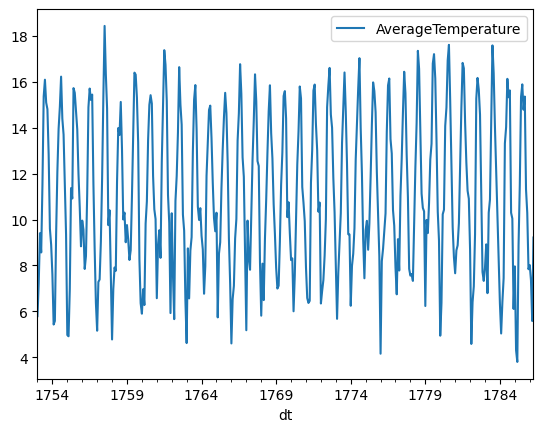

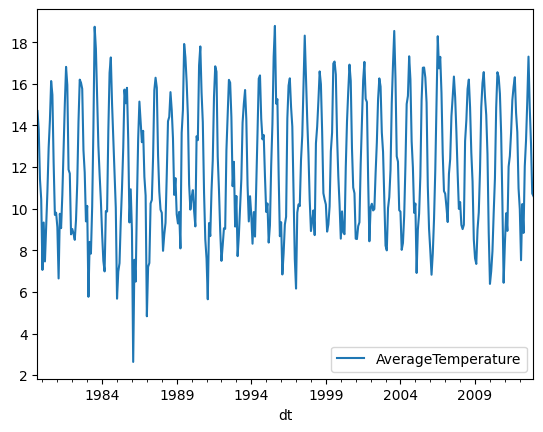

In [136]:
df_ok[:400].plot(y='AverageTemperature', kind='line')
df_ok[-400:].plot(y='AverageTemperature', kind='line')

<Axes: xlabel='dt'>

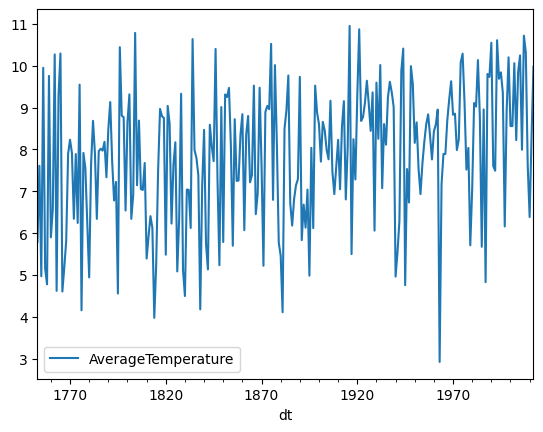

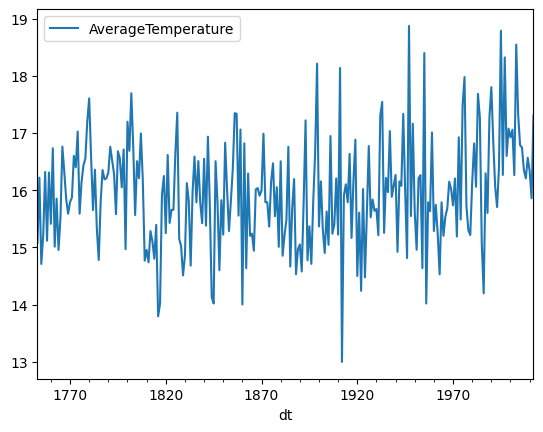

In [137]:
df_ok[::12].plot(y='AverageTemperature', kind='line')
df_ok[7::12].plot(y='AverageTemperature', kind='line')

### **Recherche de périodicité dans les données**



Nous utilisons le test de Dickey-Fuller de la librairie **Statsmodels**, ce test permet de déterminer si une série temporelle est stationnaire, c'est-à-dire si ses propriétés statistiques (espérance, variance, auto-corrélation) varie dans le temps.

https://fr.wikipedia.org/wiki/Test_de_Dickey-Fuller<br>

Ici on peut considérer que **la série temporelle est stationnaire**, ce qui semble cohérent avec les données mesurées.

In [138]:
from statsmodels.tsa.stattools import adfuller

_, pValue, _, _, _, _ = adfuller(df_ok['AverageTemperature'])
print("La p-value du test de est de: ", pValue, "la série est donc stationnaire.")

La p-value du test de est de:  1.0513211364097989e-07 la série est donc stationnaire.


**ACF** et **PACF** 

L'autocorrélation et l'autocorrélation partielle permettent de voir s'il y a une relation entre une série et ses valeurs décalées (translatées dans le temps).

https://www.geeksforgeeks.org/autocorrelation-and-partial-autocorrelation/

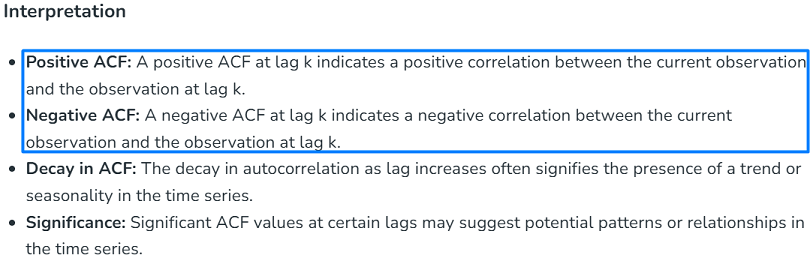

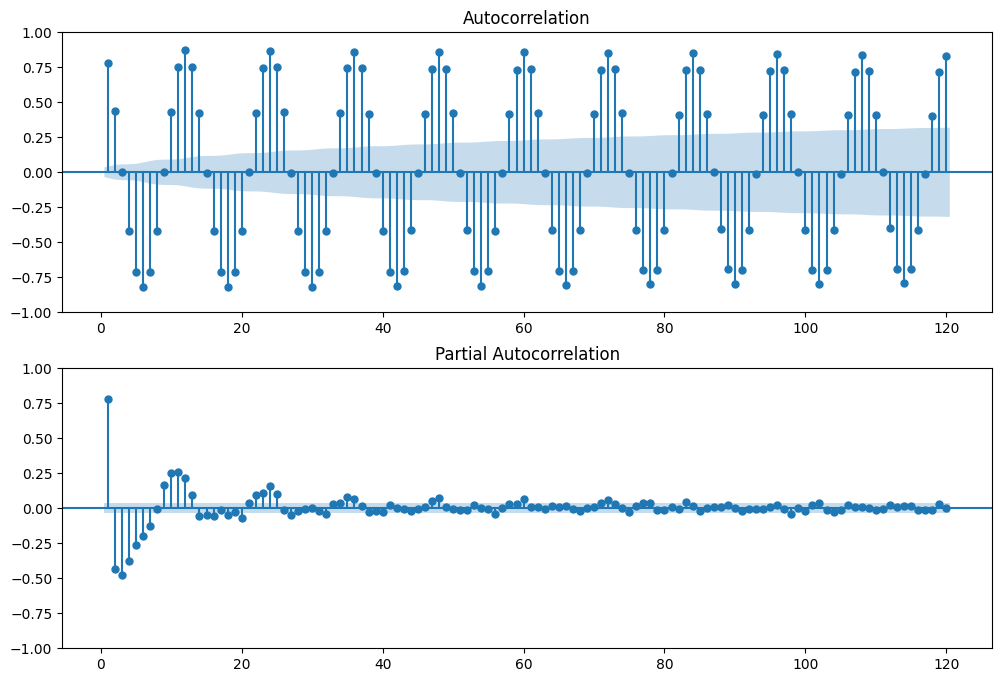

In [139]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
plot_acf(df_ok['AverageTemperature'],  lags=120, zero=False, ax=ax1);
plot_pacf(df_ok['AverageTemperature'], lags=120, zero=False, ax=ax2);

In [112]:
from statsmodels.tsa.arima.model import ARIMA

arma = ARIMA(df_ok['AverageTemperature'], order=(1,0,3)).fit()

arma.summary()

c:\Users\Utilisateur\anaconda3\envs\time_series\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Utilisateur\anaconda3\envs\time_series\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Utilisateur\anaconda3\envs\time_series\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:     AverageTemperature   No. Observations:                 3120
Model:                 ARIMA(1, 0, 3)   Log Likelihood               -6536.840
Date:                Mon, 10 Feb 2025   AIC                          13085.681
Time:                        15:40:41   BIC                          13121.954
Sample:                    01-01-1753   HQIC                         13098.702
                         - 12-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.2741      0.045    249.894      0.000      11.186      11.363
ar.L1          0.8467      0.034     24.831      0.000       0.780       0.914
ma.L1         -0.0490      0.032     -1.518      0.129      -0.112       0.014
ma.L2         -0.2875      0.024    -11.749      0.000      -0.336      -0.240
ma.L3         -0.4711      0.018    -25.722      0.000      -0.507      -0.435
sigma2         3.8654      0.105     36.929      0.000       3.660       4.071
===================================================================================
Ljung-Box (L1) (Q):                 115.82   Jarque-Bera (JB):                30.36
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                            -0.23
Prob(H) (two-sided):                  0.19   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### **Afficher les moyennes de température par mois**

**Pour la ville de Brest**

In [211]:
group_months = df_ok.groupby(['month']).agg({'AverageTemperature' : 'mean'})
group_months

,AverageTemperature
month,
1,7.844488
2,7.584915
3,7.859327
4,8.893238
5,11.125923
...,...
8,15.959892
9,14.782846
10,12.573738


<Axes: xlabel='month'>

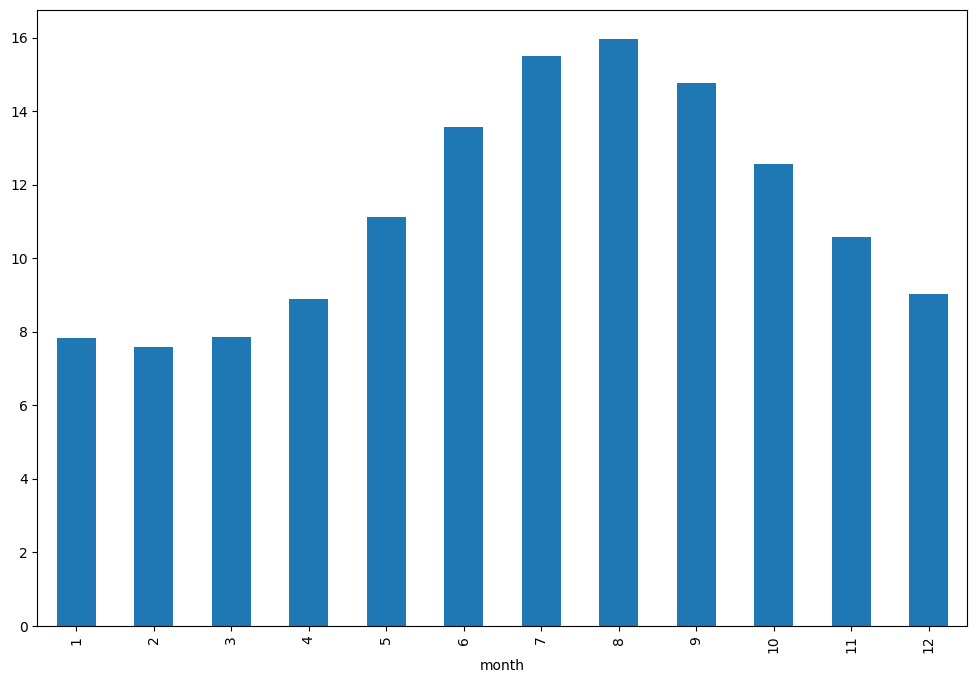

In [159]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
group_months.AverageTemperature.plot(ax = ax, kind='bar')

**Pour les autres villes de France**

In [202]:
df_france_ok = df_france_dt.copy()
print("Nb Cities in France: ", len(df_france_ok.City.unique()))
df_france_ok.City.unique()

Nb Cities in France:  36


array(['Aix En Provence', 'Amiens', 'Angers', 'Besançon', 'Bordeaux',
       'Boulogne Billancourt', 'Brest', 'Caen', 'Clermont Ferrand',
       'Dijon', 'Grenoble', 'Le Havre', 'Le Mans', 'Lille', 'Limoges',
       'Lyon', 'Marseille', 'Metz', 'Montpellier', 'Mulhouse', 'Nîmes',
       'Nancy', 'Nantes', 'Nice', 'Orléans', 'Paris', 'Perpignan',
       'Reims', 'Rennes', 'Rouen', 'Saint Étienne', 'Strasbourg',
       'Toulon', 'Toulouse', 'Tours', 'Villeurbanne'], dtype=object)

In [232]:
df_temp = df_france_ok[df_france_ok['City'] == 'Brest']
df_temp.head(3)
df_temp.rename({'month' : 'Test'}, axis='columns', inplace=True)
df_temp

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_23512\3038745496.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.rename({'month' : 'Test'}, axis='columns', inplace=True)


,dt,AverageTemperature,AverageTemperatureUncertainty,City,Test,year
1130388,1743-11-01,11.346,1.826,Brest,11,1743
1130393,1744-04-01,9.802,2.184,Brest,4,1744
1130394,1744-05-01,10.264,1.623,Brest,5,1744
1130395,1744-06-01,13.310,1.640,Brest,6,1744
1130396,1744-07-01,14.800,1.716,Brest,7,1744
...,...,...,...,...,...,...
1133621,2013-04-01,8.664,0.659,Brest,4,2013
1133622,2013-05-01,10.140,0.491,Brest,5,2013
1133623,2013-06-01,13.187,0.563,Brest,6,2013
1133624,2013-07-01,17.862,0.739,Brest,7,2013


Delta Brest : 16.24
Delta Marseille : 23.07
Delta Toulon : 23.07
Delta Caen : 23.89
Delta Le Havre : 23.89
Delta Rouen : 23.89
Delta Angers : 24.80
Delta Nantes : 24.80
Delta Rennes : 24.80
Delta Perpignan : 25.24
Delta Bordeaux : 25.34
Delta Limoges : 26.82
Delta Toulouse : 26.83
Delta Amiens : 27.14
Delta Boulogne Billancourt : 27.14
Delta Paris : 27.14
Delta Le Mans : 27.27
Delta Orléans : 27.27
Delta Tours : 27.27
Delta Aix En Provence : 27.86
Delta Montpellier : 27.86
Delta Nîmes : 27.86
Delta Clermont Ferrand : 28.20
Delta Saint Étienne : 28.20
Delta Lille : 28.22
Delta Nice : 28.40
Delta Grenoble : 29.17
Delta Lyon : 29.17
Delta Villeurbanne : 29.17
Delta Reims : 30.01
Delta Besançon : 30.30
Delta Dijon : 30.30
Delta Mulhouse : 30.45
Delta Metz : 31.40
Delta Nancy : 31.40
Delta Strasbourg : 31.40


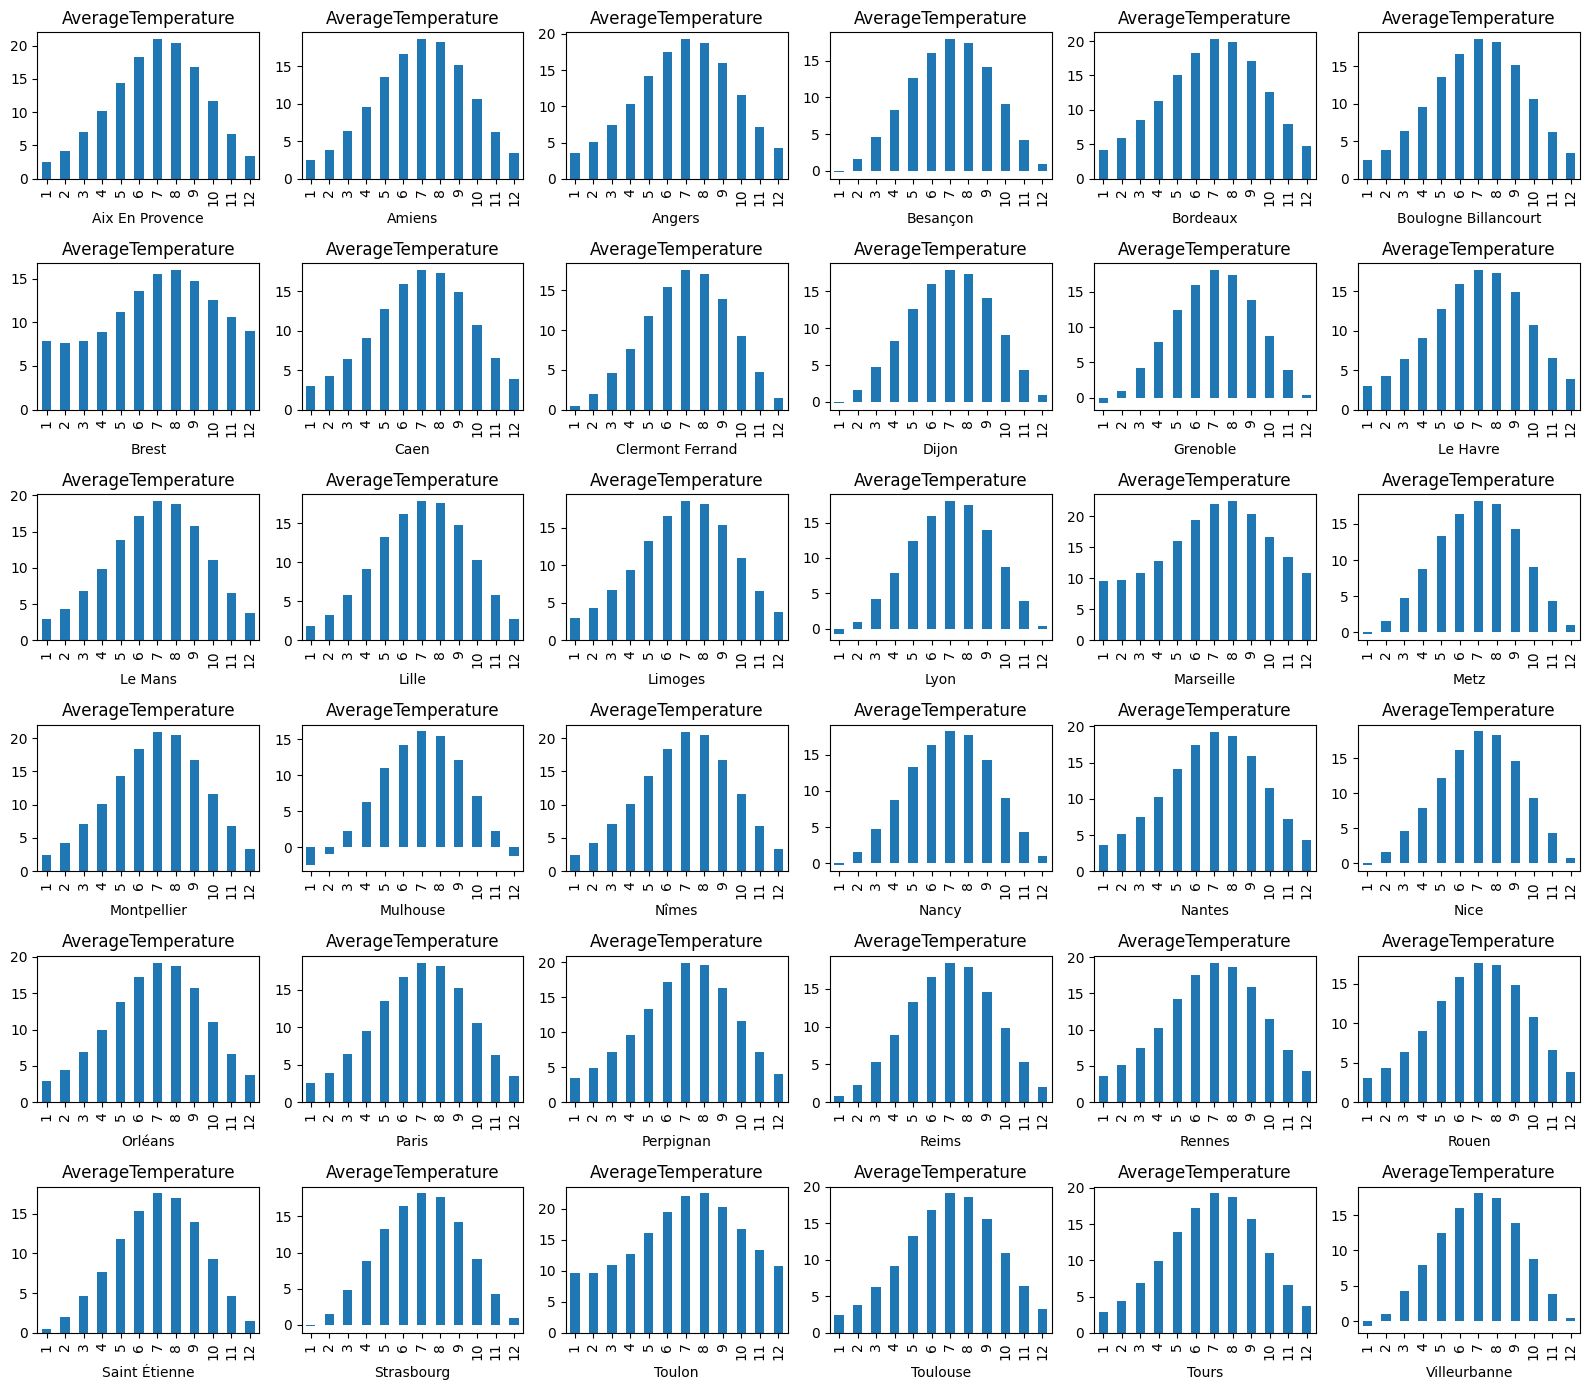

In [ ]:
lst_cities = df_france_ok.City.unique()
fig, ax = plt.subplots(6, 6, figsize=(16, 14))
delta = []

for i in range(36):
    city = lst_cities[i]
    df_temp = df_france_ok[df_france_ok['City'] == city]
    df_temp = df_temp.rename({'month' : city}, axis = 'columns')
    group_months = df_temp.groupby([city]).agg({'AverageTemperature' : 'mean'})
    group_months.AverageTemperature.plot(subplots=True, x = range(2, 14), ax = ax[i // 6, i % 6], kind='bar')
    delta.append((city, np.max(df_temp['AverageTemperature'].values) - np.min(df_temp['AverageTemperature'].values)))

fig.tight_layout()

delta.sort(key = lambda x : x[1])
for (city, d) in delta:
    print(f"Delta {city} : {d:.2f}")